# 개요

* 아래의 목적/이유로 참가한 스터디에 대한 기록
  * SQLD취득 후 장기 미사용 & GPT를 통한 SQL사용 등으로 많이 잊은 SQL을 복기
  * 기존에 사용해 본 Optuna가 아닌 Autogluon이 커리큘럼에 있어 익혀보고자 함
  * 기존에 관심있던 XAI(설명가능한 AI)를 익히고자 함

* 5주차 과제 진행
  * 지난 과제의 모델에 대해 SHAP로 Feature importance구하기
  * Feature Selection 후 재학습해보기
  * 재학습한 모델에 대해 SHAP 시각화 & 변수 설명해보기

# 5주차 과제 

## 과제 설명

* 과제 : 월간 데이콘 신용카드 사용자 연체 예측 AI 경진대회
  * https://dacon.io/competitions/official/235713/overview/description
* 아래 내용 진행해보기
  * 지난 과제에서 학습시켜 본 모델에 대해, SHAP를 통해 FI구하기
  * Feature Selection 후 재학습해보기
  * 재학습한 모델에 대해 SHAP의 다양한 시각화 적용 & 변수의 설명력 구해보기

## 전처리 해둔 데이터 읽고 데이터셋 나누기

In [ ]:
from pkb_sqlite3 import DB_sqlite3
from sklearn.model_selection import train_test_split
import pandas as pd

db_controller = DB_sqlite3('Dacon_creditcard_overdue.db')
df_train = db_controller.search_db_show_df('SELECT * FROM train')
df_train_pre = db_controller.search_db_show_df('SELECT * FROM train_pre')
df_test = db_controller.search_db_show_df('SELECT * FROM test_pre')
df_sample_submission = db_controller.search_db_show_df('SELECT * FROM sample_submission')

train = pd.concat([df_train_pre, df_train['credit']], axis=1)
x_test = df_test.copy()

# index컬럼 삭제
train = train.drop(columns=['index'])
x_test = x_test.drop(columns=['index'])

x_train, x_validate = train_test_split(train, test_size=0.3, random_state=42, stratify=train['credit'])

## SHAP로 Feature Importance 구하기

* SHAP를 위한 모델 학습

In [ ]:
from imblearn.over_sampling import ADASYN
from lightgbm import LGBMClassifier, early_stopping
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, log_loss
import shap


def model_practice_with_LGBMClassifier(X_train, y_train, X_validate, y_validate):
    model = LGBMClassifier(class_weight="balanced", random_state=42)
    model.fit(X_train, 
            y_train,
            eval_set=[(X_validate, y_validate)],
            eval_metric='logloss',callbacks=[early_stopping(stopping_rounds=10)],
            )

    y_pred = model.predict(X_validate)
    y_proba = model.predict_proba(X_validate)

    accuracy = accuracy_score(y_validate, y_pred)
    logloss = log_loss(y_validate, y_proba)
    cf_matrix = confusion_matrix(y_validate, y_pred)
    classify_report = classification_report(y_validate, y_pred)

    result_dict = {'model':model,
                   'y_pred':y_pred,
                   'y_proba':y_proba,
                   'accuracy':accuracy,
                   'logloss':logloss,
                   'cf_matrix':cf_matrix,
                   'classify_report':classify_report
                   }
    
    return result_dict


# 오버샘플링
ADASYN_sampler = ADASYN(random_state=42)
X_train, y_train = ADASYN_sampler.fit_resample(x_train.drop(['credit'], axis = 1), x_train["credit"])
X_validate, y_validate = ADASYN_sampler.fit_resample(x_validate.drop(['credit'], axis = 1), x_validate["credit"])

# 모델학습
result_default = model_practice_with_LGBMClassifier(X_train, y_train, X_validate, y_validate)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7336
[LightGBM] [Info] Number of data points in the train set: 35665, number of used features: 33
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.749591


* SHAP Feature Importance : SHAP 절대값의 평균
  * 각 feature에 대해 절대값의 평균을 구함
  * axis 설명
    * axis 0 : row (각 샘플)
    * axis 1 : feature
    * axis 2 : class (출력값, 위 모델에서의 credit)
  * `np.mean(np.abs(shap_values_train), axis=(0, 2))`
    * row와 class를 따라 계산해, feature importance를 계산

In [ ]:
import numpy as np

# Explainer를 활용한 SHAP 계산
explainer = shap.TreeExplainer(result_default['model'])
shap_values_train = explainer.shap_values(X_train)

# 전체 SHAP값의 절대값의 평균으로 Feature Importance 구하기
shap_values_mean = np.mean(np.abs(shap_values_train), axis=(0, 2))  # (35,) 크기

print(f"""SHAP value의 Shape              : {shap_values_train.shape}
SHAP Feature Importance의 Shape : {shap_values_mean.shape}""")

SHAP value의 Shape              : (35665, 35, 3)
SHAP Feature Importance의 Shape : (35,)


* 데이터프레임 & 오름차순 표기

In [ ]:
import pandas as pd

feature_importance = pd.DataFrame({
    'Feature': [f'{X_train.columns[i]}' for i in range(shap_values_mean.shape[0])],
    'Importance': shap_values_mean
}).sort_values(by='Importance', ascending=False)

feature_importance

,Feature,Importance
34,begin_month,0.208791
12,income_type_Working,0.182263
2,gender_F,0.169896
0,edu_type,0.160190
4,car_N,0.154671
6,reality_N,0.153865
14,family_type_Married,0.110945
25,child_num,0.083134
8,income_type_Commercial associate,0.074013
9,income_type_Pensioner,0.069626


## Feature Selection 후 재학습

In [ ]:
# 0보다 큰 Feature Select
list_selected_feature = feature_importance[feature_importance['Importance']>0]['Feature'].tolist()

# Feature Selection 적용한 데이터셋
X_train_filtered = X_train.loc[:, list_selected_feature]
X_validate_filtered = X_validate.loc[:, list_selected_feature]

# 모델학습
result_feature_selected = model_practice_with_LGBMClassifier(X_train_filtered, y_train, X_validate_filtered, y_validate)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001743 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7336
[LightGBM] [Info] Number of data points in the train set: 35665, number of used features: 33
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[95]	valid_0's multi_logloss: 0.749591


## 재학습한 모델에 대해 SHAP의 다양한 시각화 적용 & 변수의 설명력 구해보기

* 재학습한 모델에 대한 SHAP계산

In [ ]:
import numpy as np

# Explainer를 활용한 SHAP 계산
explainer_featured = shap.TreeExplainer(result_feature_selected['model'])
shap_values_train_featured = explainer_featured.shap_values(X_train_filtered)

# 전체 SHAP값의 절대값의 평균으로 Feature Importance 구하기
shap_values_mean_featured = np.mean(np.abs(shap_values_train_featured), axis=(0, 2))  # (35,) 크기

print(f"""SHAP value의 Shape              : {shap_values_train_featured.shape}
SHAP Feature Importance의 Shape : {shap_values_mean_featured.shape}""")

SHAP value의 Shape              : (35665, 33, 3)
SHAP Feature Importance의 Shape : (33,)


### SHAP Summary plot

* Class 0 : 신용도가 높음
  * 일해서 돈을 버는 사람일수록(income_type_Working높음) / 증가
  * 결혼하지 않은 사람일수록(family_type_Married) / 증가
  * 신용카드 발급이 오래된 사람일수록(begin_month) / 증가
    * 데이터수집일을 기준으로 0부터 역으로 센 음수변수(값이 작을수록 오래됨)
  * income_total...?

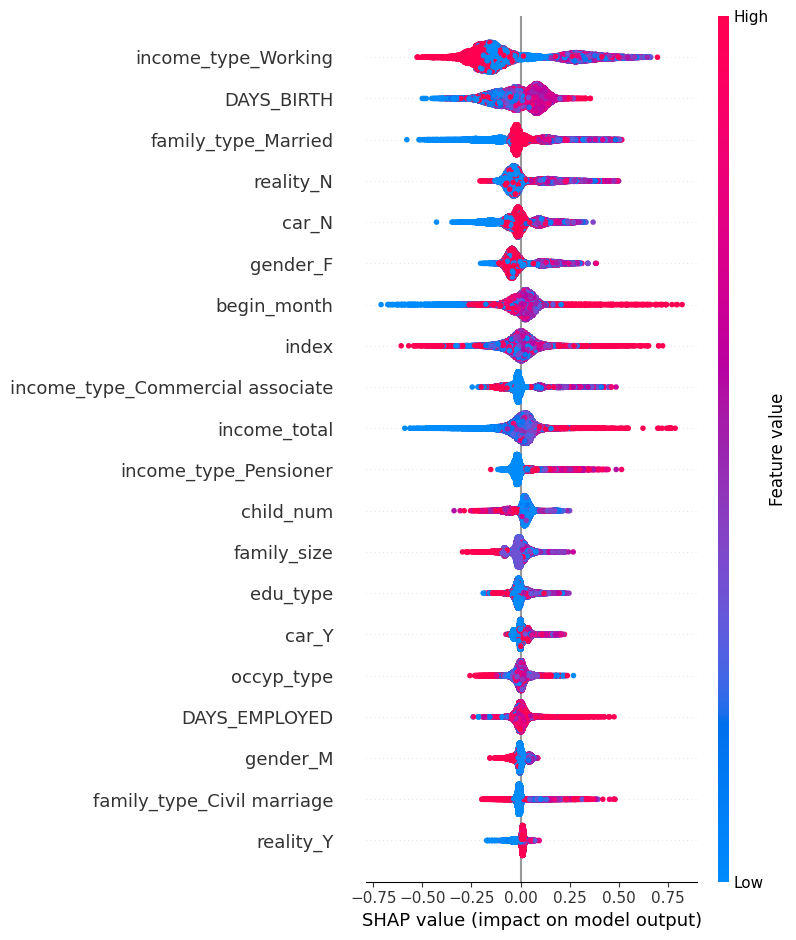

In [ ]:
shap.summary_plot(shap_values_train_featured[:, :, 0], 
                  X_train_filtered, 
                  feature_names=X_train_filtered.columns,)

* Class 2 : 신용도가 낮음
  * 신용카드 발급이 오래된 사람일수록(begin_month) / 증가
    * 데이터수집일을 기준으로 0부터 역으로 센 음수변수(값이 작을수록 오래됨)

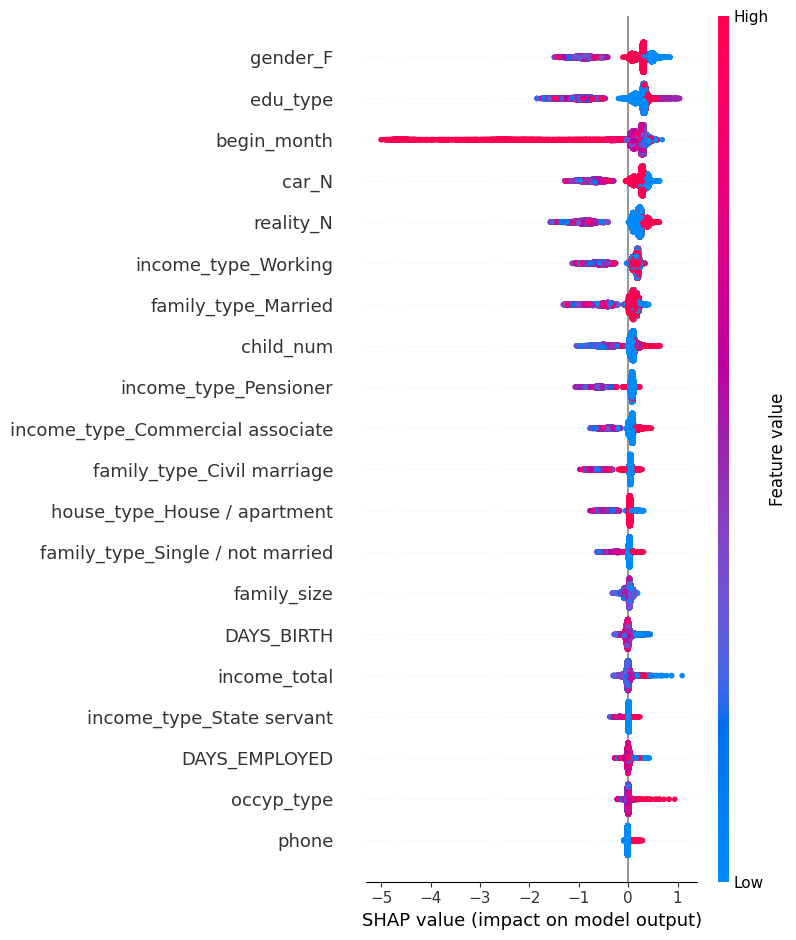

In [ ]:
shap.summary_plot(shap_values_train_featured[:, :, 2], 
                  X_train_filtered, 
                  feature_names=X_train_filtered.columns,)

### SHAP Feature Importance plot

* Class 0 : 신용도가 높음
  * income_type_Working / 영향력이 큼

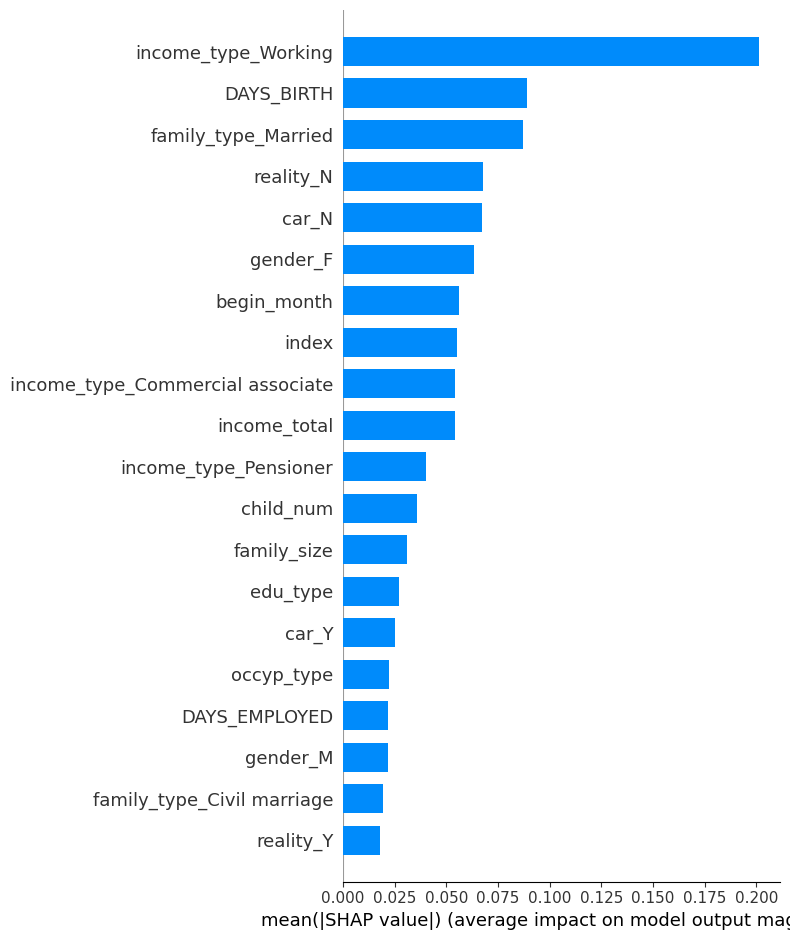

In [ ]:
shap.summary_plot(shap_values_train_featured[:, :, 0],
                  X_train_filtered,
                  plot_type='bar')

* Class 2 : 신용도가 낮음
  * 성별, 교육수준, 신용카드 발급기간, 자동차 및 부동산 소유 여부의 영향력 큼

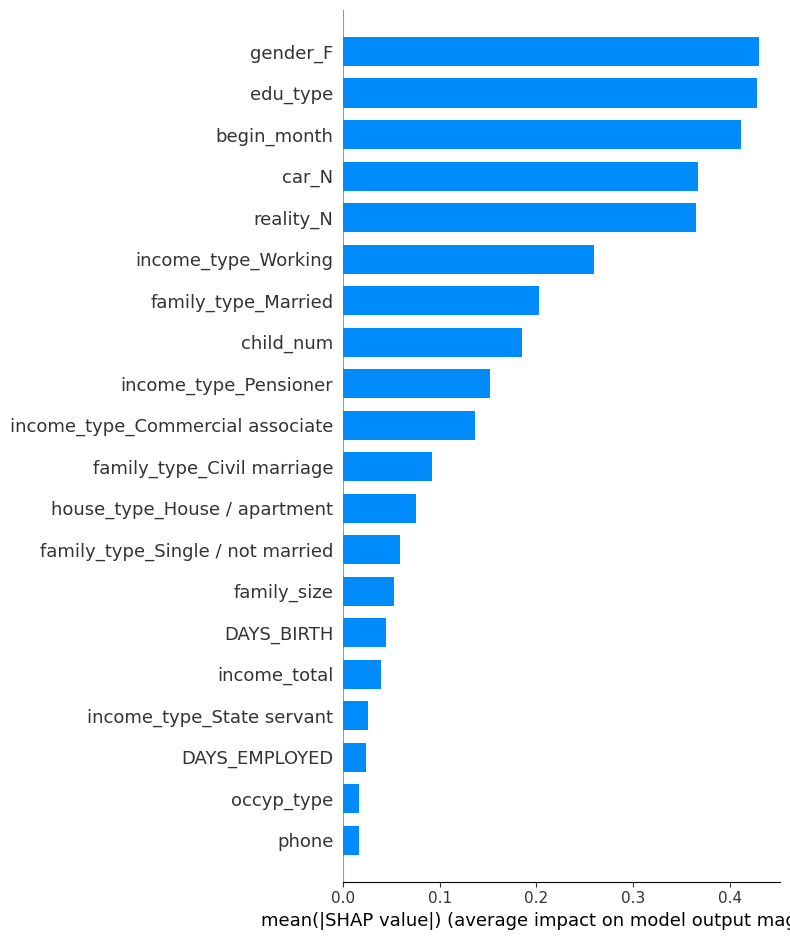

In [ ]:
shap.summary_plot(shap_values_train_featured[:, :, 2],
                  X_train_filtered,
                  plot_type='bar')

### SHAP Depenence plot

* Feature importance에서 특정 경향이 강했던 변수 위주의 확인(Class 0 : 신용도가 높음)
  * income_type_Working : 전 구간에서 양의 영향을 끼침

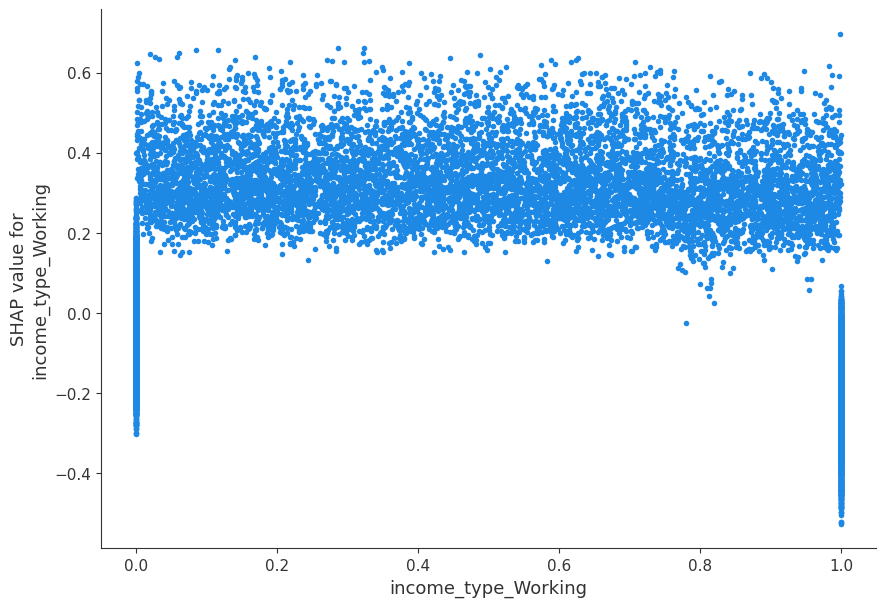

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10,7))
shap.dependence_plot("income_type_Working", 
                     shap_values_train_featured[:, :, 0], 
                     X_train_filtered, 
                     interaction_index=None, ax=ax)

* Feature importance에서 특정 경향이 강했던 변수 위주의 확인(Class 2 : 신용도가 낮음)
  * gender_F : 전 구간에서 음의 영향을 끼침

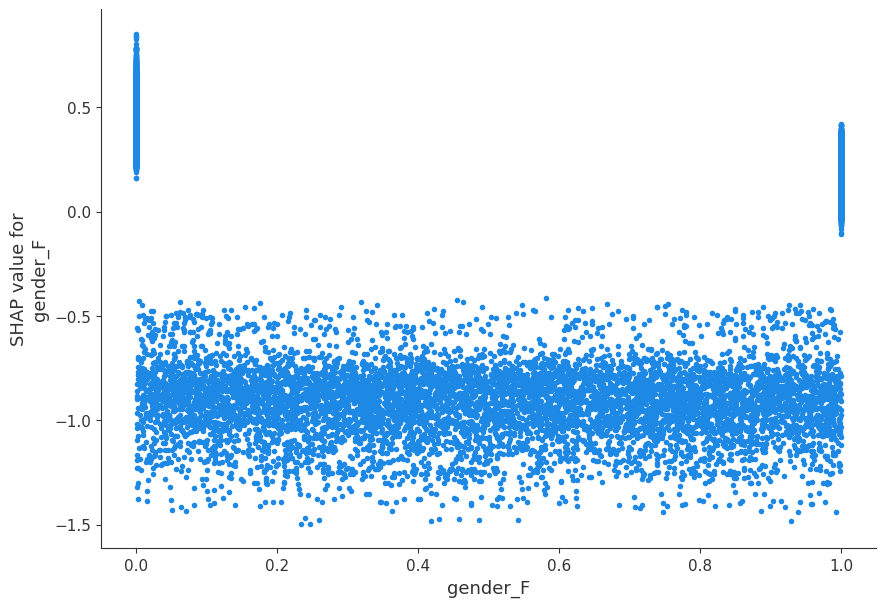

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(10,7))
shap.dependence_plot("gender_F", 
                     shap_values_train_featured[:, :, 2], 
                     X_train_filtered, 
                     interaction_index=None, ax=ax)

* edu_type : 1을 임계점으로하여, 낮은 경우 양의 영향 / 높은 경우 음의 영향

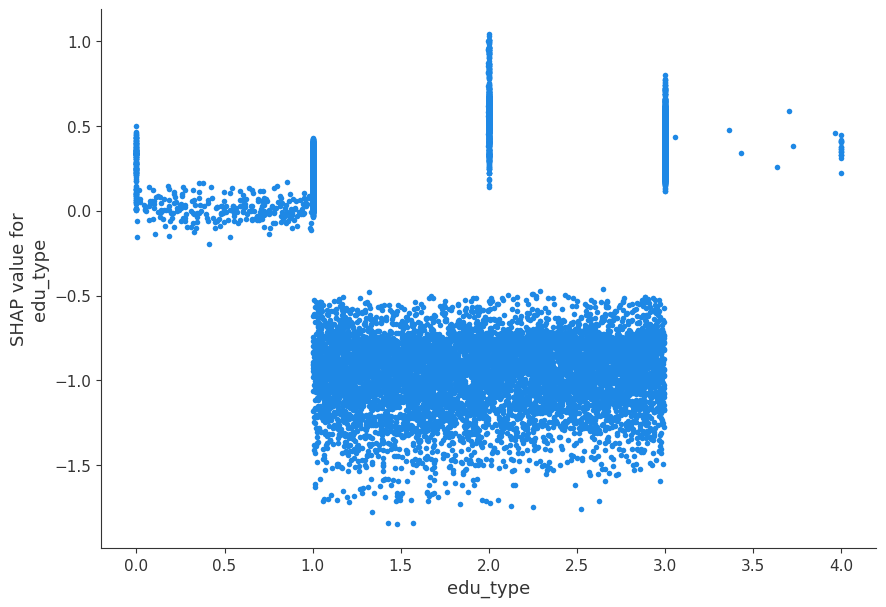

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))
shap.dependence_plot("edu_type", 
                     shap_values_train_featured[:, :, 2], 
                     X_train_filtered, 
                     interaction_index=None, ax=ax)

* begin_month : 약 1.2를 임계점으로하며, 이보다 높은 경우 음의 영향

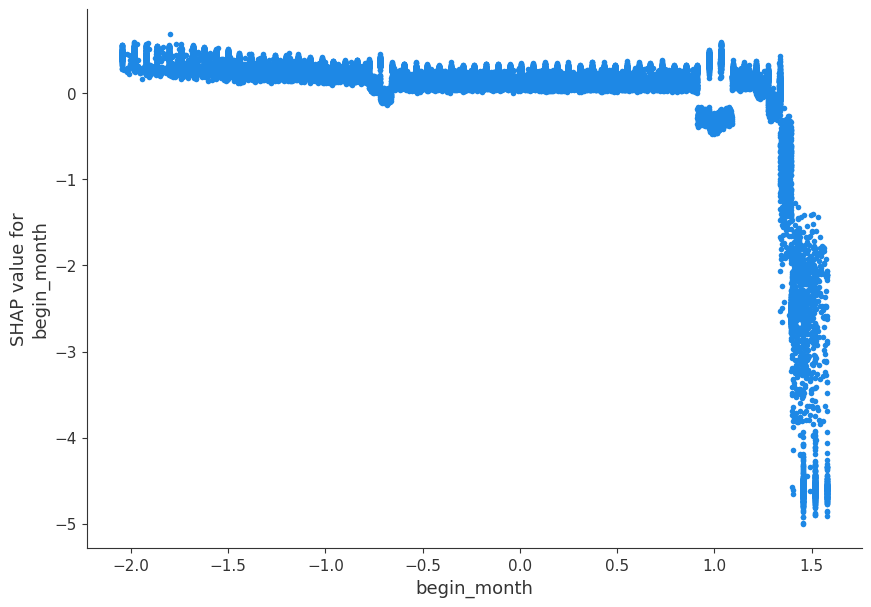

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10,7))
shap.dependence_plot("begin_month", 
                     shap_values_train_featured[:, :, 2], 
                     X_train_filtered, 
                     interaction_index=None, ax=ax)

### SHAP Force plot

* 샘플로 1가지만 실습
  * 0번(사람)에 대해, 모델이 예측값을 산출할 때
    * income_type_Working이 음의 영향을 줌(0일수록 높은 신용도)
    * 컬럼에 index가 있던 것을 발견함. 데이터 전처리로직에서 index컬럼삭제해도록 반영해 둠

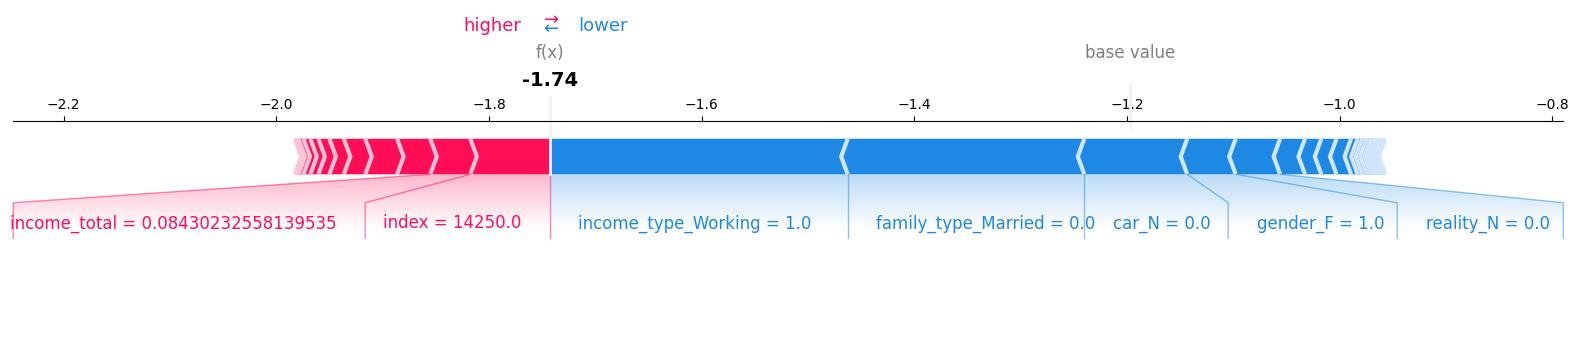

In [ ]:
class_label = 0 # credit 0, 1, 2 중 택1
row_number = 0  # 확인해보고 싶은 데이터 row

shap.force_plot(explainer_featured.expected_value[class_label], 
                shap_values_train_featured[row_number, :, class_label], 
                X_train_filtered.iloc[row_number, :],
                matplotlib=True)